Grass BGR color:  (58.31609856575068, 106.75901570301424, 80.40141474184612)


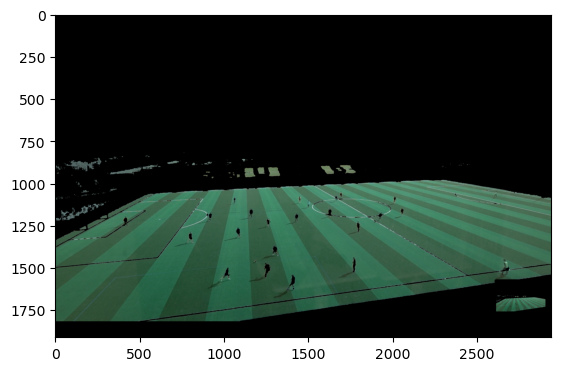

In [21]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from ultralytics import YOLO

# Convert image to HSV color space
img = cv2.imread('test/3.png')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define a large range of green color in HSV
lower_green = np.array([30, 40, 40])
upper_green = np.array([80, 255, 255])

# Threshold the HSV image to get only green colors
mask = cv2.inRange(hsv, lower_green, upper_green)

# Calculate the mean value of the pixels that are not masked
masked_img = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(masked_img)
grass_color = cv2.mean(img, mask=mask)
grass_color = grass_color[:3]
print("Grass BGR color: ", grass_color)

In [22]:
path = "/Users/othmaneechchabi/Desktop/College/Undergrad/DKU SPRING 2024/COMPSCI302/dku_football/kvs_game/weights/best_nafie.pt"
# model_players = YOLO(path)
# player_model_conf_thresh = 0.50
# # Run YOLOv8 players inference on the frame
# results_players = model_players(img, conf=player_model_conf_thresh)

# ## Extract detections information
# bboxes_p = results_players[0].boxes.xyxy.cpu().numpy()                # Detected players, referees and ball (x,y,x,y) bounding boxes
# bboxes_p_c = results_players[0].boxes.xywh.cpu().numpy()              # Detected players, referees and ball (x,y,w,h) bounding boxes    
# labels_p = list(results_players[0].boxes.cls.cpu().numpy())           # Detected players, referees and ball labels list
# confs_p = list(results_players[0].boxes.conf.cpu().numpy())           # Detected players, referees and ball confidence level

# # Get bounding boxes information (x,y,w,h) of detected players (label 0) and balls (label 2)
# bboxes_p_c_0 = bboxes_p_c[[i==0 for i in labels_p],:]
# bboxes_p_c_2 = bboxes_p_c[[i==2 for i in labels_p],:]

Grass BGR color:  (58.31609856575068, 106.75901570301424, 80.40141474184612)

0: 480x736 17 Players, 1 GoalKeeper, 1 Main Referee, 296.2ms
Speed: 2.2ms preprocess, 296.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 736)


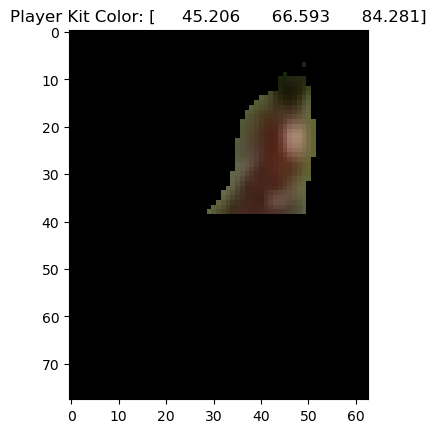

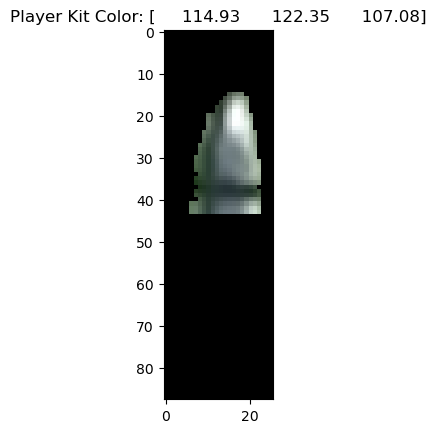

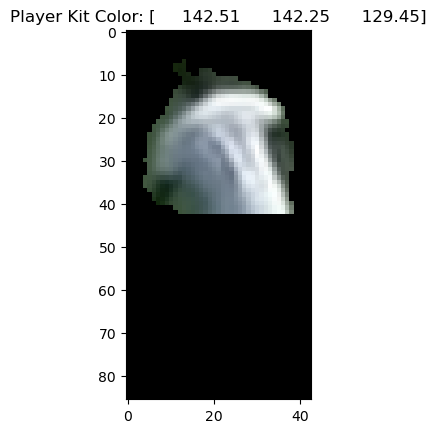

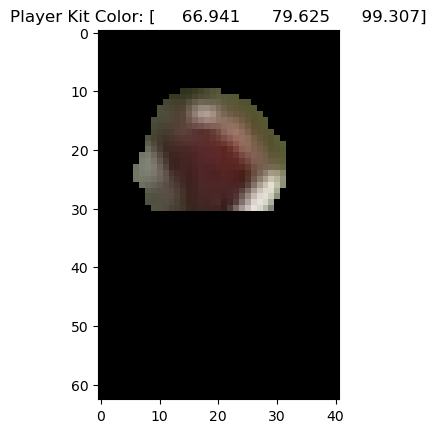

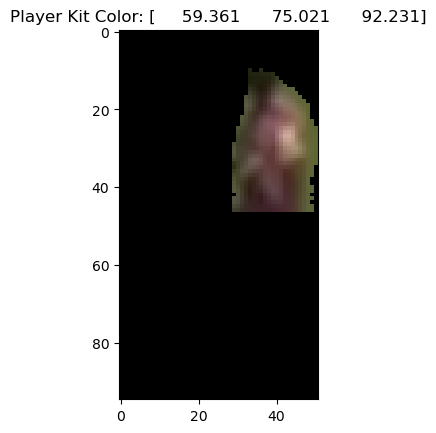

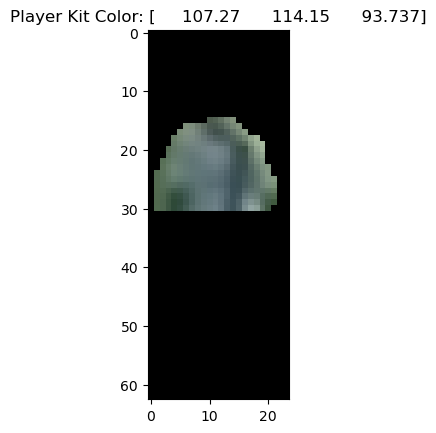

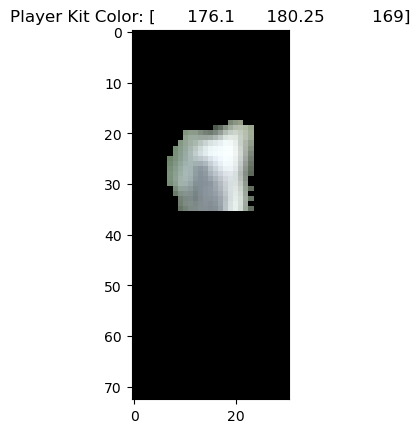

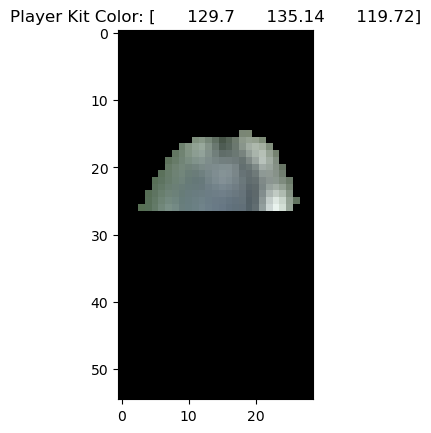

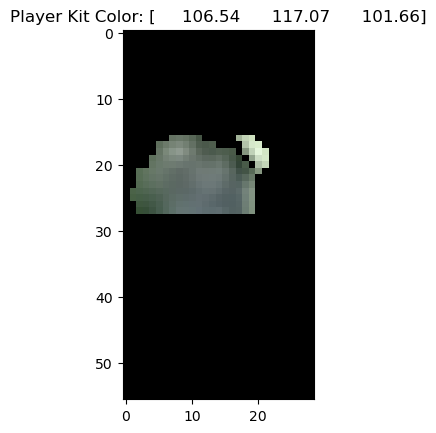

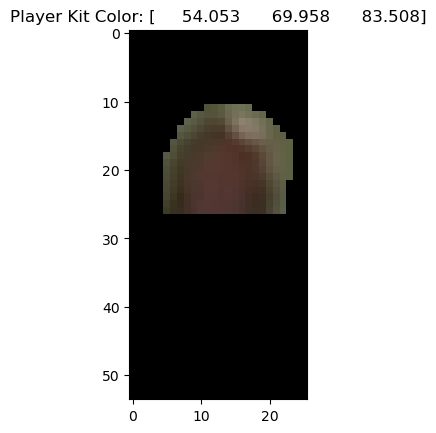

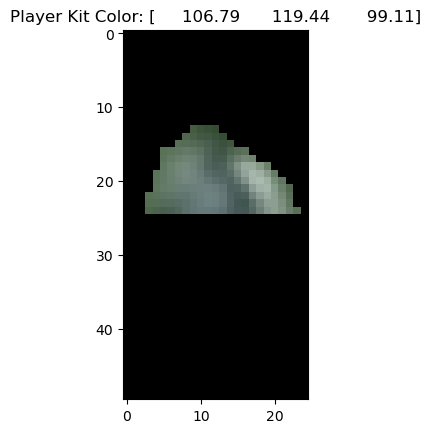

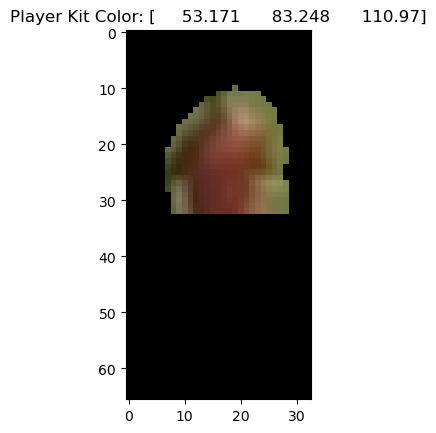

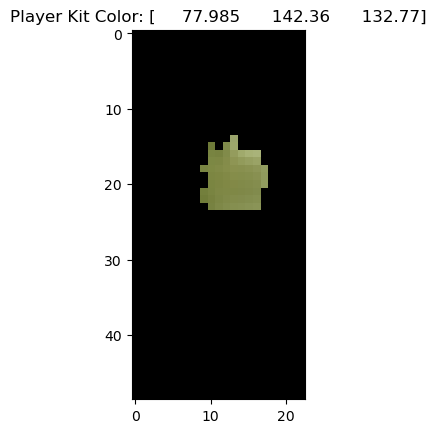

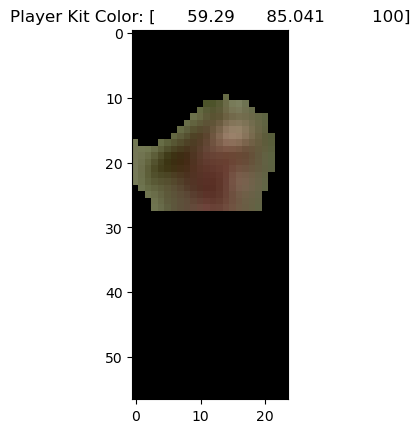

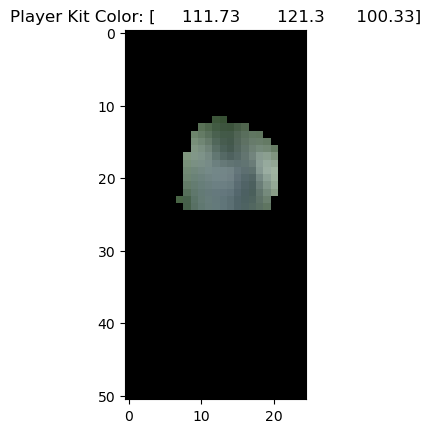

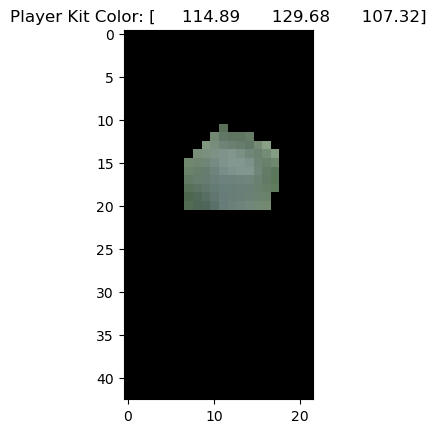

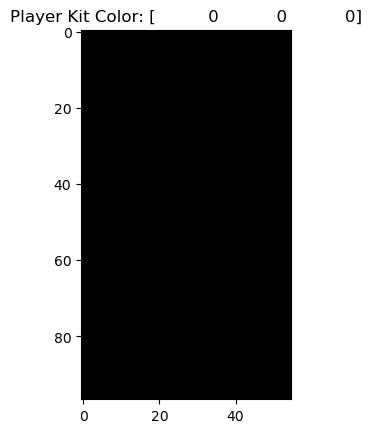

In [23]:
import numpy as np
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load and prepare the image
img = cv2.imread('test/3.png')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
lower_green = np.array([30, 40, 40])
upper_green = np.array([80, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)
masked_img = cv2.bitwise_and(img, img, mask=mask)

# Calculate and display the average grass color
grass_color = cv2.mean(img, mask=mask)[:3]
print("Grass BGR color: ", grass_color)

# Load the model
model_players = YOLO(path)
player_model_conf_thresh = 0.50

# Perform detection
results_players = model_players(img, conf=player_model_conf_thresh)

# Extract detection data
bboxes_p = results_players[0].boxes.xyxy.cpu().numpy() 
labels_p = list(results_players[0].boxes.cls.cpu().numpy())
confs_p = list(results_players[0].boxes.conf.cpu().numpy())

kits_colors = []
grass_hsv = cv2.cvtColor(np.uint8([[list(grass_color)]]), cv2.COLOR_BGR2HSV)

# Process each detection
for i, label in enumerate(labels_p):
    if label == 0:  # Assuming '0' is the label for players
        x1, y1, x2, y2 = map(int, bboxes_p[i])
        player_img = img[y1:y2, x1:x2]
        hsv = cv2.cvtColor(player_img, cv2.COLOR_BGR2HSV)

        # Adjust the green range based on the average grass color
        lower_green = np.array([grass_hsv[0, 0, 0] - 10, 40, 40])
        upper_green = np.array([grass_hsv[0, 0, 0] + 10, 255, 255])
        mask = cv2.inRange(hsv, lower_green, upper_green)
        mask = cv2.bitwise_not(mask)

        # Apply a mask to get the upper half of the player (typically where the kit is most visible)
        upper_mask = np.zeros(player_img.shape[:2], np.uint8)
        upper_mask[0:player_img.shape[0]//2, :] = 255
        mask = cv2.bitwise_and(mask, upper_mask)
        masked_img = cv2.bitwise_and(player_img, player_img, mask=mask)

        # Calculate the mean color of the player's kit
        player_kit_color = np.array(cv2.mean(player_img, mask=mask)[:3])
        kits_colors.append(player_kit_color)

        # Display results
        plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Player Kit Color: {player_kit_color}")
        plt.show()


In [24]:
import numpy as np
from sklearn.cluster import KMeans
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

# Assuming kits_colors contains the BGR colors of the player kits extracted previously
kits_colors = np.array(kits_colors)

# Apply K-means clustering to classify the kits into two distinct colors
kits_kmeans = KMeans(n_clusters=2)
kits_kmeans.fit(kits_colors)

# Convert the BGR color format to RGB for visualization
kits_colors_rgb = kits_colors[:, [2, 1, 0]]  # Reversing BGR to RGB
cluster_centers_rgb = kits_kmeans.cluster_centers_[:, [2, 1, 0]]

# Create a 3D scatter plot of the kit colors
fig = px.scatter_3d(
    x=kits_colors_rgb[:, 0],
    y=kits_colors_rgb[:, 1],
    z=kits_colors_rgb[:, 2],
    range_x=[0, 255],
    range_y=[0, 255],
    range_z=[0, 255],
    title="Kits Colors Clustering",
    color=kits_kmeans.labels_
)

# Add the cluster centers to the plot
fig.add_scatter3d(
    x=cluster_centers_rgb[:, 0],
    y=cluster_centers_rgb[:, 1],
    z=cluster_centers_rgb[:, 2],
    mode='markers',
    marker=dict(color='black', size=10, symbol='cross'),
    name='Cluster Centers'
)

fig.show()